In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from mpl_toolkits.mplot3d import Axes3D  # registers the 3D projection

# Black–Scholes Option Pricing & Greeks

## Pricing Formulas (no dividends, continuous compounding)

$$
C = S_0 \, N(d_1) - K e^{-rT} N(d_2),
$$

$$
P = K e^{-rT} N(-d_2) - S_0 \, N(-d_1),
$$
where
$$
d_1 = \frac{\ln\!\left(\frac{S_0}{K}\right) + \left(r + \frac{1}{2} \sigma^2\right) T}{\sigma \sqrt{T}},
\qquad
d_2 = d_1 - \sigma \sqrt{T}.
$$

---

## Greeks (for calls; puts via parity)

$$
\Delta_{\text{call}} = N(d_1),
$$
$$
\Gamma = \frac{\phi(d_1)}{S_0 \, \sigma \sqrt{T}},
$$
$$
\text{Vega} = S_0 \, \phi(d_1) \, \sqrt{T},
$$
$$
\Theta_{\text{call}} = -\frac{S_0 \, \phi(d_1) \, \sigma}{2 \sqrt{T}} - r K e^{-rT} N(d_2),
$$
$$
\rho_{\text{call}} = K T e^{-rT} N(d_2).
$$

> **Note:** Vega above is per **1.00** change in volatility. Divide by 100 to get “per vol point” (1% vol).

---

## Put Greeks (via put–call parity)

$$
\Delta_{\text{put}} = N(d_1) - 1,
$$
$$
\Theta_{\text{put}} = -\frac{S_0 \, \phi(d_1) \, \sigma}{2 \sqrt{T}} + r K e^{-rT} N(-d_2),
$$
$$
\rho_{\text{put}} = -K T e^{-rT} N(-d_2).
$$

---

## Variable Glossary

- $S_0$: current underlying price  
- $K$: strike price  
- $T$: time to maturity (in years)  
- $r$: risk-free interest rate (continuous compounding)  
- $\sigma$: volatility of returns (annualized)  
- $N(\cdot)$: standard normal cumulative distribution function  
- $\phi(\cdot)$: standard normal probability density function  

---

## Notes

- **With continuous dividend yield $q$**:  
  Replace $S_0$ with $S_0 e^{-qT}$,  
  and in $d_1$ replace $r$ with $r - q$.
- **Put–call parity (no dividends)**:  
  $$
  C - P = S_0 - K e^{-rT}.
  $$


In [2]:
N = norm.cdf

In [3]:
#  d1, d2 computation according to Black-Scholes framework

def d1(K, S0, r, sigm, T):
    return (np.log(S0/K) + (r + (sigm**2) / 2)*T) / (sigm*np.sqrt(T))

In [4]:
def d2(K, S0, r, sigm, T):
    return d1(K, S0, r, sigm, T) - sigm*np.sqrt(T)

In [10]:
def greek_delta(K, S0, r, sigm, T):
    return N(d1(K, S0, r, sigm, T))

In [15]:
S_vals = np.linspace(60, 140, 60)
T_vals = np.linspace(0.05, 2.0, 60)

In [16]:
S_grid, T_grid = np.meshgrid(S_vals, T_vals)

In [17]:
K = 100
r = 0.02
sigm = 0.2

In [18]:
delt = greek_delta(K, S_grid, r, sigm, T_grid)

In [19]:
S_grid, T_grid = np.meshgrid(S_vals, T_vals)

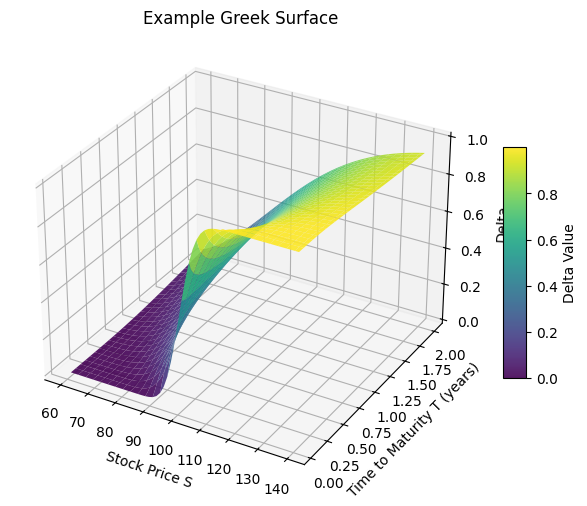

In [20]:
# Create 3D figure
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot surface
surf = ax.plot_surface(S_grid, T_grid, delt,
                       cmap='viridis', edgecolor='none', alpha=0.9)

# Labels
ax.set_xlabel('Stock Price S')
ax.set_ylabel('Time to Maturity T (years)')
ax.set_zlabel('Delta')

# Add color bar
fig.colorbar(surf, shrink=0.5, aspect=10, label='Delta Value')

plt.title("Example Greek Surface")
plt.show()